In [135]:
#import library
from scipy.stats import norm
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math

import seaborn as sns
import pandas as pd
%matplotlib inline

Define the prior by multuvatiate distribution

In [136]:
mu= [0.,0.]

cov = [[ 1,  0.],
        [ 0.,  1]]


In [137]:
## initial the model

c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

## define the log probability
def joint_log_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

<b>RMH

In [138]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(D, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)
samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 1.3%


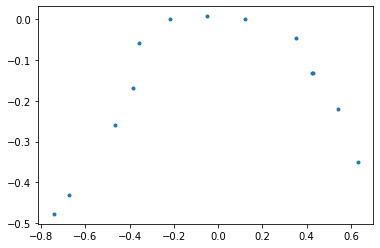

In [139]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


Adjust the step size

In [140]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1.7 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

dtype = np.float32

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(D, *args)

# adjust the step size of Random walk Matroplis Hasting MCMC
def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

samples, kernel_results= tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.1, dtype=dtype),
        seed=42))  # For determinism.


samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 22.3%


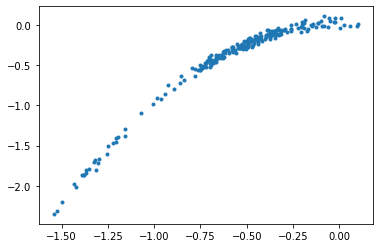

In [141]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


<b> HMC

In [142]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 99.2%


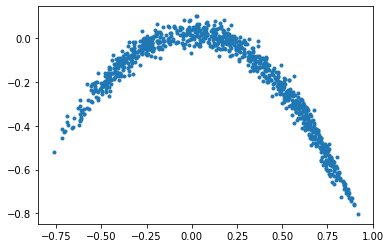

In [143]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


<b> Hessian MCMC - banana v1.0

Set up the target probability density

In [144]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
np.random.seed(0)
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

mean = [0.,0.]

@tf.function
def joint_log_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mean,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))


In [145]:
joint_log_prob(D,0.,0.)

<tf.Tensor: id=28893186, shape=(), dtype=float32, numpy=-144.7019>

<b> Gradient Descent

In [146]:
### Block out in case run by accident, takes too long to run 28 min
# mu = tf.constant([-1., -1.])
# for i in range(1000000):
#     with tf.GradientTape() as t:  
#         t.watch(mu)
#         theta1 = mu[0]
#         theta2 = mu[1]
#         loss = tf.negative(joint_log_prob(D,theta1,theta2))
#         dlossdmu = t.gradient(loss,mu)
#         print(mu.numpy(),dlossdmu.numpy())
#         mu = mu - 0.00001*dlossdmu

Let's take (0,0) as MAP for now

In [147]:
MAP = [-0.00024201,  0.05921397]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)

A new hessian function 2019-11-27

In [148]:
# Create an empty matrix to store hessian matrix
hess = np.empty([MAP.shape[0],MAP.shape[0]])

In [149]:
## new hessian function
with tf.GradientTape(persistent=True) as t:  
    t.watch(MAP)
    theta1 = MAP[0]
    theta2 = MAP[1]
    loss = tf.negative(joint_log_prob(D,theta1,theta2))
    jacobian = t.gradient(loss,MAP)
    print('gradient:',jacobian.numpy())
    for i in range(MAP.shape[0]):
        hess[i] = t.gradient(jacobian[i],MAP)
    print(hess)

gradient: [-0.00021326 -0.00018563]
[[ 8.81224275e-01 -4.84020039e-02]
 [-4.84020002e-02  1.01000000e+02]]


let's test the hessian calculation in a simple algebra case

In [150]:
# define a simple function : x^3 + 2* y^2 +x^3*y^3
def f(vars):
    return(vars[0]**3+2*vars[1]**2+vars[0]**3*vars[1]**3)

MAP = [1., 1.]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)

with tf.GradientTape(persistent=True) as t:  
    hess = np.empty([MAP.shape[0],MAP.shape[0]])
    t.watch(MAP)
    loss = f(MAP)
    jacobian = t.gradient(loss,MAP)
    print('gradient:',jacobian.numpy())
    for i in range(MAP.shape[0]):
        hess[i] = t.gradient(jacobian[i],MAP)
    print(hess)

gradient: [6. 7.]
[[12.  9.]
 [ 9. 10.]]


So the hessian function is correct  
let's make it in to a function

In [151]:
# define a function to compute full hessian
def hessian_compute_new(fn,loc):
    f_ = fn
    loc_ = loc
    hess = np.empty([loc.shape[0],loc.shape[0]])
    with tf.GradientTape(persistent=True) as t:  
        t.watch(loc_)
        loss = f_(loc_)
        jacobian = t.gradient(loss,loc_)
        for i in range(loc_.shape[0]):
            hess[i] = t.gradient(jacobian[i],loc_)
    return hess

In [152]:
MAP = [-0.00024201,  0.05921397]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)
# define a loss function which is the negative log posterior
def lossfunction(vars):
    return(tf.negative(joint_log_prob(D,vars[0],vars[1])))
hess = hessian_compute_new(lossfunction,MAP)
print(hess)

[[ 8.81224275e-01 -4.84020039e-02]
 [-4.84020002e-02  1.01000000e+02]]


The Hessian of the log posterior shows the second derivative of $\theta_1$ is much smaller than $\theta_2$ , which makes sense, because the banana on $\theta_2$  direction have a much greater curvature

Simple example of different curvature in geometry

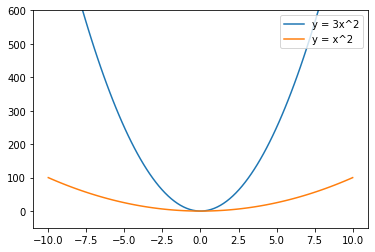

In [153]:
x = np.linspace(-10,10,100)
y_1 = 10*x**2
y_2 = x**2
fig, ax = plt.subplots()
ax.plot(x,y_1,label = 'y = 3x^2')
ax.plot(x,y_2,label = 'y = x^2')
ax.set_ylim(top = 600)
ax.legend(loc = 'upper right')

In [154]:
def hessian_compute_new(fn,loc):
    f_ = fn
    loc_ = loc
    hess = np.empty([loc.shape[0],loc.shape[0]])
    with tf.GradientTape(persistent=True) as t:  
        t.watch(loc_)
        loss = f_(loc_)
        jacobian = t.gradient(loss,loc_)
        for i in range(loc_.shape[0]):
            hess[i] = t.gradient(jacobian[i],loc_)
    return hess

In [155]:
def f(x):
    return x**2
loc = tf.zeros(1)
hessian_compute_new(f,loc)

array([[2.]])

In [156]:
def f(x):
    return 3*x**2
loc = tf.zeros(1)
hessian_compute_new(f,loc)

array([[6.]])

#### Compute the Hessian and Covariance of the Posterior at MAP

Laplace approximation

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [157]:
cov = tf.convert_to_tensor(cov,dtype = tf.float32)
tf.linalg.inv(cov)

<tf.Tensor: id=28897551, shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [158]:
Sum = tf.add(hess,tf.linalg.inv(cov))
C_post = tf.linalg.inv(Sum)
C_post

<tf.Tensor: id=28897555, shape=(2, 2), dtype=float32, numpy=
array([[5.3157514e-01, 2.5224808e-04],
       [2.5224808e-04, 9.8040411e-03]], dtype=float32)>

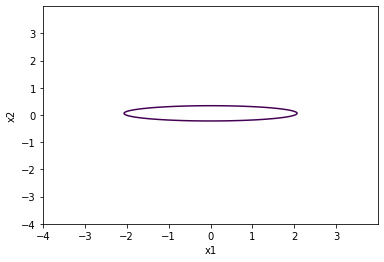

In [321]:
from scipy.stats import multivariate_normal
def plot_dist(loc,cov):
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(loc, cov)
    plt.contour(x, y, rv.pdf(pos),np.arange(0.04,0.05,0.075))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_dist(MAP,C_post)

#### Define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}


gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

$\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}$  is the negative log posterior

In [160]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

In [169]:
def negative_log_prob(vars):
    return(tf.negative(joint_log_prob(D,vars[0],vars[1])))

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_prob(m_current),matrixcompute(m_current,MAP,C_post))
    delta_proposed = tf.subtract(negative_log_prob(m_proposed),matrixcompute(m_proposed,MAP,C_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        

In [170]:
from IPython.display import clear_output
# define leaning rate
beta = 0.1

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed
    

    

In [171]:
mu_init = [1.,1.]

acceptance rate = 84.3%


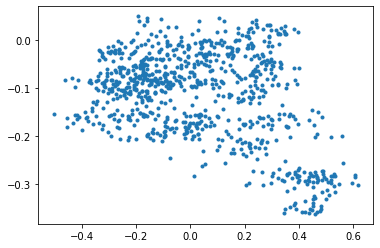

In [322]:
number_of_steps = 1000
def run_chain():
    burn_in = 500
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(accepted[:,0],accepted[:,1],'.')


In [337]:
number_of_steps = 10000
def run_chain():
    burn_in = 500
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()

In [338]:
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

acceptance rate = 83.4%


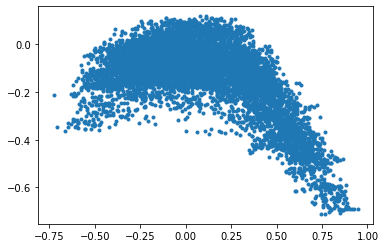

In [340]:
accepted = np.array(accepted)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(accepted[:,0],accepted[:,1],'.')


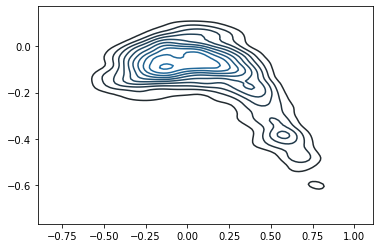

In [339]:
sns.kdeplot(accepted)

### Tascks: 
1.  make a plot of the true density
2.  Create a gempy model, better with gravity


Likelihood

In [ ]:
s = 0.01  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-2, 2+s, s)   #Could use linspace instead if dividing
Y = np.arange(-2, 2.+s, s)   #evenly instead of stepping...

#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.01,0.05,0.09])

Prior

In [ ]:
def plot_Prior():
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_Prior()

Try again put them in a inference problem

In [288]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.prob(tf.squeeze(z))
           +tf.reduce_sum(y.prob(D))))

In [289]:
y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
tf.reduce_prod(y.prob(D))

<tf.Tensor: id=153311083, shape=(), dtype=float32, numpy=0.0>

In [290]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

post = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_post_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

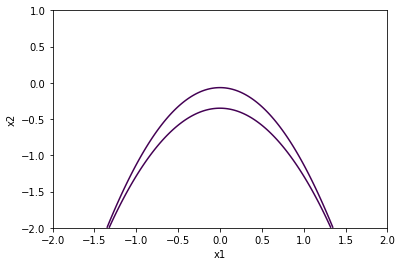

In [298]:
plt.contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")

#### make a function to plot the true density

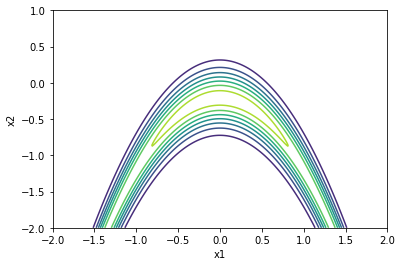

In [317]:
def plot_truepost():
    plt.contour(x, y, post)
    plt.xlim(-2,2)
    plt.ylim(-2,1)
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_truepost()

likelihood

In [278]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def likelihood_prob(y,theta1,theta2):
    # define random variables prior
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(tf.exp(tf.reduce_sum(y.prob(D))))

In [279]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y
likelihood = np.empty(x.shape)
for i in range(400):
    for j in range(400):
        likelihood[i][j] = likelihood_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

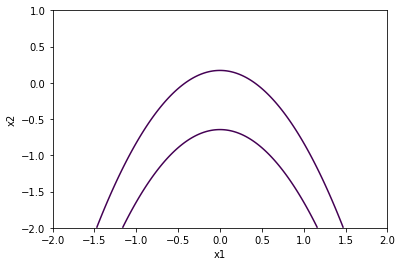

In [299]:
plt.contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")
    

Prior

In [218]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def prior_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    return(mvn.prob(tf.squeeze(z)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

prior = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        prior[i][j] = prior_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

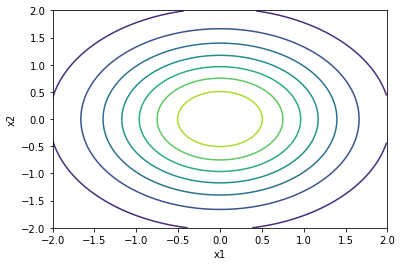

In [219]:
plt.contour(x, y, prior)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Let's add more observations, we shall expect broader extension

In [191]:
c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.prob(tf.squeeze(z))
          +tf.reduce_sum(y.prob(D)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

pdf_1 = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        pdf_1[i][j] = joint_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

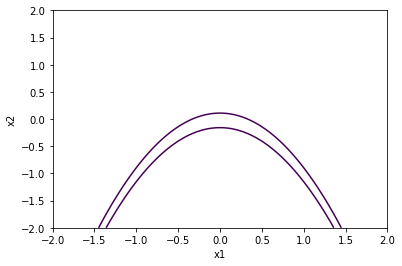

In [192]:
plt.contour(x, y, pdf_1,[joint_prob(D,0.1,0.1).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Plot the results together

Text(0.5, 1.0, '(c) Posterior')

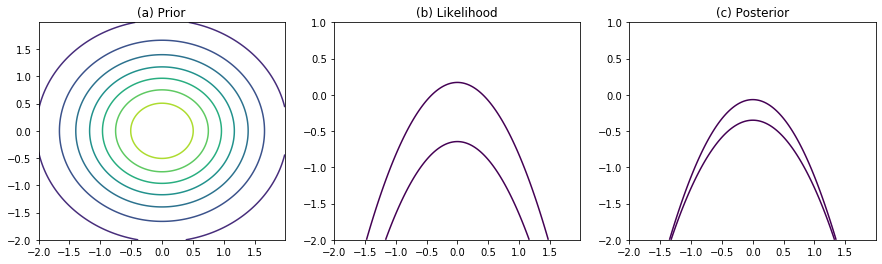

In [318]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

(a) Prior, (b) likelihood and (c) posterior for the warped bivariate Gaussian distribution with n=100 values generated from the likelihood with parameter settings $\sigma_y$,$\sigma$ = 11: as the sample size increases and the prior becomes more diffuse, the posterior becomes less identifiable and the ridge in the posterior becomes stronger 

In [329]:
post.shape

(400, 400)

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: No contour levels were found within the data range.


Text(0, 0.5, 'x2')

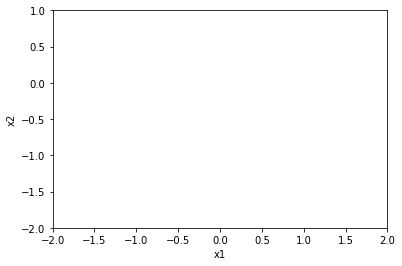

In [330]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.log_prob(tf.squeeze(z))
           +tf.reduce_sum(y.log_prob(D))))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

post = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_post_prob(D,pos[i][j][0],pos[i][j][1])
        

In [332]:
post

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: No contour levels were found within the data range.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'x2')

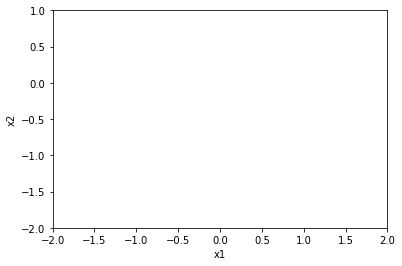

In [333]:
plt.contour(x, y, post)
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")